In [88]:
import pandas as pd 
import numpy as np 
from collections import defaultdict
import plotly.graph_objects as go
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.impute import SimpleImputer
from Binning import WOE
from sklearn.preprocessing import OneHotEncoder
from xarray import *
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from lightgbm import LGBMClassifier
import scorecardpy as sc
from lifelines import KaplanMeierFitter

## Context

This project aims to develop an application credit scorecard for a financial institution which extends loans to subprime customers (pay-day loans). First, I will run univariate and bivariate analysis and pre-process the data, then perform different models and evalute each model's performance. Finally,I will choose the best one to be our final scorecard.

In [2]:
os.getcwd()

'c:\\Users\\warfaoui\\OneDrive - IESEG\\Desktop\\Credit Scoring\\Project'

In [3]:
Data = "./Data"

In [4]:
Accepts = pd.read_csv(Data + "/RealEstateLoans_accepts.csv")

In [5]:
Rejects = pd.read_csv(Data + "/RealEstateLoans_rejects.csv")

## EDA
According the exploratory data analysis for the **Accepts** data, the defaulting persons represent 8.5% of the the total clients who got loans.  
The distribution of the job titles, the majority of borrowers are *laborers* followed by *Sales Stuff* and *core stuff*. 72% of these clients have pursued *Secondary Education* as the highest academic grade.  

The total income density curve shows a right tail shape, what tells us that most of the clients don't have high income.  
To conclude, we can say that the profiling of the clients are mid-range citizens with no high education and average salaries.   

Moving to bivariate analysis, I tried to see the relation between the income variable and defaulting, and between the latter and family status.  We can infer that the defaulting is more for Single status members in the data set. As for the boxplots for the total income and defaulting, the IQR for customers who defaulted is the same for those who did not, which means that there is no effect of the income on their behaviours. 

In [6]:
# dataset dimensions
Accepts.shape

(18549, 29)

In [7]:
Accepts.head()

,total_income,loan_amount,term,interest_rate,own_car,own_house,nr_children,income_type,education_type,family_status,...,occupation_type,family_count,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,Default
0,157500.0,288562.5,30,3.737395,Y,N,0,Commercial associate,Secondary / secondary special,Married,...,Drivers,2.0,NaN,0.541308,0.236611,0,0,0,0,0
1,76500.0,225000.0,48,3.654300,N,Y,3,Working,Secondary / secondary special,Separated,...,Laborers,4.0,NaN,0.395423,0.673830,0,1,0,0,0
2,67500.0,409653.0,12,3.262865,Y,N,0,Working,Secondary / secondary special,Civil marriage,...,Laborers,2.0,NaN,0.649417,0.042929,0,1,0,0,1
3,180000.0,328405.5,24,4.773736,Y,N,1,Working,Secondary / secondary special,Separated,...,Laborers,2.0,0.512811,0.337838,0.852828,0,1,0,0,0
4,130500.0,1225224.0,60,2.867961,N,N,0,Pensioner,Secondary / secondary special,Married,...,NaN,2.0,0.595440,0.537174,0.367291,0,0,0,0,0


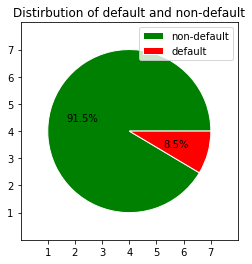

In [8]:
# Share of target variable values
fig, ax = plt.subplots()
ax.pie(Accepts["Default"].value_counts(), colors=["green","red"], radius=3, center=(4, 4),
       wedgeprops={"linewidth": 1, "edgecolor": "white"}, frame=True,autopct='%1.1f%%')
ax.set_title("Distirbution of default and non-default")
ax.legend(["non-default","default"])
ax.set(xlim=(0, 8), xticks=np.arange(1, 8),
       ylim=(0, 8), yticks=np.arange(1, 8))
plt.show()

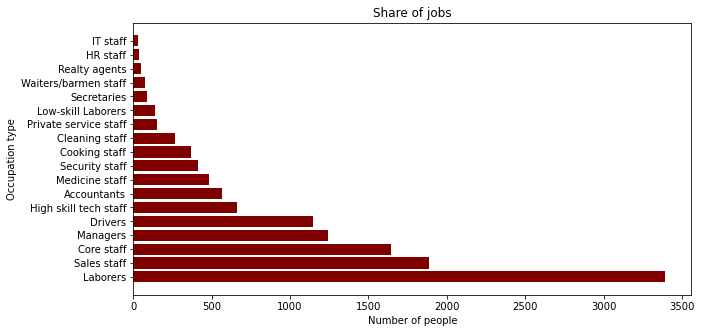

In [9]:
# percentage of each job
occup = Accepts["occupation_type"].value_counts(normalize=True).keys()
values = Accepts["occupation_type"].value_counts().values
fig = plt.figure(figsize=(10, 5))
  
plt.barh(occup, values, color='maroon')
plt.xlabel("Number of people")
plt.ylabel("Occupation type")
plt.title("Share of jobs")
plt.show()

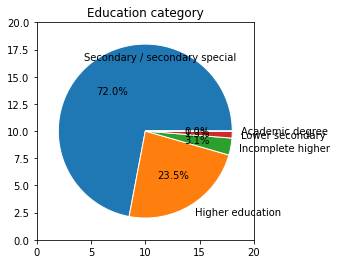

In [10]:
# Percentage of education categories
fig, ax = plt.subplots()
ax.pie(Accepts["education_type"].value_counts(normalize=True),labels=Accepts["education_type"].value_counts().keys(),radius=8, center=(10, 10),
       wedgeprops={"linewidth": 1, "edgecolor": "white"},frame=True,autopct='%1.1f%%')
ax.set_title("Education category")
ax.set(xlim=(0, 20),
       ylim=(0, 20))
plt.show()

Text(0.5, 1.0, 'Income distribution')

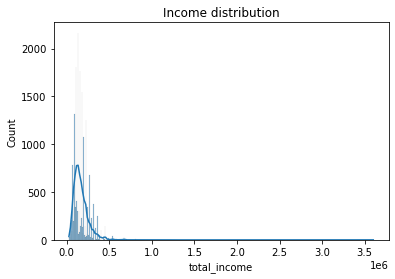

In [11]:
# distribution of income
sns.histplot(x='total_income', data=Accepts,kde=True)
plt.title("Income distribution")

In [12]:
Accepts[Accepts["total_income"]==3600000.0]

,total_income,loan_amount,term,interest_rate,own_car,own_house,nr_children,income_type,education_type,family_status,...,occupation_type,family_count,EXT1,EXT2,EXT3,EXT4,EXT5,EXT6,EXT7,Default
7068,3600000.0,953460.0,30,3.180429,Y,N,0,Commercial associate,Higher education,Married,...,NaN,2.0,0.723817,0.588615,0.681706,0,1,0,0,0
14231,3600000.0,1113840.0,60,3.325668,Y,N,0,Working,Secondary / secondary special,Single / not married,...,Core staff,1.0,NaN,0.526475,0.746300,0,0,0,0,0


C:\tools\Anaconda3\envs\py\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


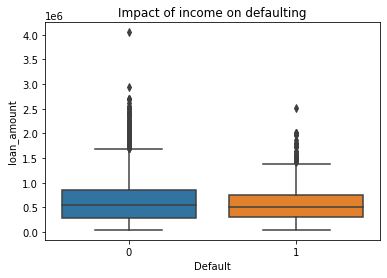

In [13]:
# impact of income on defaulting
sns.boxplot(Accepts["Default"], Accepts["loan_amount"])
plt.title("Impact of income on defaulting")
plt.show()

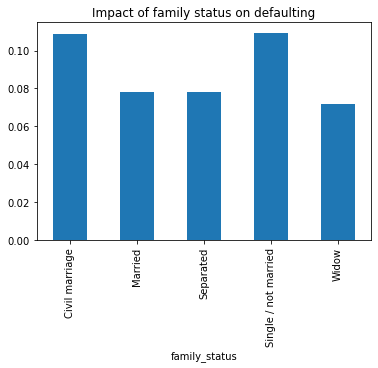

In [14]:
# Impact of family status on defaulting
Accepts.groupby('family_status')['Default'].mean().plot.bar()
plt.title("Impact of family status on defaulting")
plt.show()

## Preprocessing
We move to the pre-processing process, where I first checked whether all the variables have the same type as the ones mentioned in the data description. Then I checked the missing values, where I droped the variables that have missing values more than 30% of the totlal number of rows. Then I split the data into **Train**, **Test** and **Validation**, in order to apply preprocessing while avoiding **data leakage**.  First, I impute the **mean** in the place of the missing values and I created variables to keep track of these missings. Then, I checked the variance of the variables and I ended up dropping **EXT7** as it has only 1 value.  

Second step is to check outliers using the **Interquartile Range** method. Since for certain variables, the outliers can make sense such as *loan amount* and *total amount*, I made the choice of changing the outliers by upper and lower values for the variable **days_employed**.  Next, I converted the variables **own_car** and **own_house** to binary variables where 1 will take the place of **Yes** and 0 of **No**. 

In [15]:
Accepts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18549 entries, 0 to 18548
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   total_income             18549 non-null  float64
 1   loan_amount              18549 non-null  float64
 2   term                     18549 non-null  int64  
 3   interest_rate            18549 non-null  float64
 4   own_car                  18549 non-null  object 
 5   own_house                18549 non-null  object 
 6   nr_children              18549 non-null  int64  
 7   income_type              18549 non-null  object 
 8   education_type           18549 non-null  object 
 9   family_status            18549 non-null  object 
 10  housing_type             18549 non-null  object 
 11  region_population_ratio  18549 non-null  float64
 12  days_birth               18549 non-null  int64  
 13  days_employed            18549 non-null  int64  
 14  days_registration     

In [16]:
# check NAs
Accepts.isna().sum()

total_income                   0
loan_amount                    0
term                           0
interest_rate                  0
own_car                        0
own_house                      0
nr_children                    0
income_type                    0
education_type                 0
family_status                  0
housing_type                   0
region_population_ratio        0
days_birth                     0
days_employed                  0
days_registration              0
mobile_number                  0
phone_number                   0
email                          0
days_phone_change              0
occupation_type             5922
family_count                   0
EXT1                       10415
EXT2                          33
EXT3                        3640
EXT4                           0
EXT5                           0
EXT6                           0
EXT7                           0
Default                        0
dtype: int64

In [17]:
Accepts.columns

Index(['total_income', 'loan_amount', 'term', 'interest_rate', 'own_car',
       'own_house', 'nr_children', 'income_type', 'education_type',
       'family_status', 'housing_type', 'region_population_ratio',
       'days_birth', 'days_employed', 'days_registration', 'mobile_number',
       'phone_number', 'email', 'days_phone_change', 'occupation_type',
       'family_count', 'EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7',
       'Default'],
      dtype='object')

In [18]:
predictors =['total_income', 'loan_amount', 'term', 'interest_rate','nr_children','region_population_ratio','days_birth','days_employed',
        'days_registration','mobile_number','phone_number', 'email','days_phone_change','family_count', 'EXT1', 'EXT2', 'EXT3', 'EXT4', 'EXT5', 'EXT6', 'EXT7','own_car',
        'own_house','income_type', 'education_type','family_status', 'housing_type','occupation_type']
target =  ['Default']       

In [19]:
Accepts = Accepts[predictors+target]
Rejects = Rejects[predictors]

In [20]:
# train test split
X = Accepts[predictors]
y = Accepts[target]

#Split data in train (80%), test (40%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y, random_state=42)

#Split test in test (20%), validation (20%)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5, stratify = y_test, random_state=42)

#Reset Index 
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
Train_data = pd.concat([X_train,y_train],axis=1)
X_valid = X_valid.reset_index(drop=True)
y_valid= y_valid.reset_index(drop=True)
Valid_data = pd.concat([X_valid,y_valid],axis=1)
X_test = X_test.reset_index(drop=True)
y_test= y_test.reset_index(drop=True)
test_data = pd.concat([X_test,y_test],axis=1)

In [21]:
# Drop num variables with more than 30% missing values
na_threshold = 0.3

na_pct = Train_data[predictors].isnull().mean()
predictors = na_pct[na_pct <= na_threshold].index.tolist()
print("Drop variables with high missing pct:", na_pct[na_pct > na_threshold].tolist())

Drop variables with high missing pct: [0.5625842393746069, 0.31871686584598796]


In [22]:
# check remaining null columns
Train_data[predictors].columns[Train_data[predictors].isnull().any()]

Index(['EXT2', 'EXT3'], dtype='object')

In [23]:
# Numerical variables
# Build the missing value imputor using the mean
miss_vars = ['EXT2', 'EXT3']
na_vars = []

imp = SimpleImputer(missing_values=np.nan, strategy='mean', add_indicator=True)
imp.fit(Train_data[miss_vars])

# Reconstruct the list of vars + indicators
na_vars = na_vars + [miss_vars[v] + "_na" for v in imp.indicator_.features_]
impute_vars = miss_vars + na_vars

# Apply on train,valid and test
Train_data[impute_vars] = pd.DataFrame(imp.transform(Train_data[miss_vars]), columns=impute_vars)
Valid_data[impute_vars] = pd.DataFrame(imp.transform(Valid_data[miss_vars]), columns=impute_vars)
test_data[impute_vars] = pd.DataFrame(imp.transform(test_data[miss_vars]), columns=impute_vars)
Rejects[impute_vars] = pd.DataFrame(imp.transform(Rejects[miss_vars]), columns=impute_vars)

In [24]:
# ne predictors list
predictors = ['total_income',
 'loan_amount',
 'term',
 'interest_rate',
 'nr_children',
 'region_population_ratio',
 'days_birth',
 'days_employed',
 'days_registration',
 'mobile_number',
 'phone_number',
 'email',
 'days_phone_change',
 'family_count',
 'EXT4',
 'EXT5',
 'EXT6',
 'EXT7',
 'own_car',
 'own_house',
 'income_type',
 'education_type',
 'family_status',
 'housing_type']

In [25]:
Train_data = Train_data[predictors+impute_vars+target]
Valid_data = Valid_data[predictors+impute_vars+target]
test_data = test_data[predictors+impute_vars+target]
Rejects= Rejects[predictors+impute_vars]

In [26]:
# Count number of unique values of each variable
vars_nunique = Train_data[predictors+impute_vars].apply(pd.Series.nunique, dropna=False, axis=0)
cont_vars = vars_nunique.index[vars_nunique < 2].tolist()

# Update train, test
Train_data = Train_data.drop(labels=cont_vars, axis=1)
Valid_data= Valid_data.drop(labels=cont_vars, axis=1)
test_data = test_data.drop(labels=cont_vars, axis=1)
Rejects= Rejects.drop(labels=cont_vars, axis=1)

In [27]:
from scipy import stats
var = ["days_employed"]
get_iqr = lambda x: {"lower":x.quantile(0.25) - 1.5 * stats.iqr(x), "upper":x.quantile(0.75) + 1.5 * stats.iqr(x)}

# compute iqr
iqr_train = Train_data[var].apply(get_iqr)
iqr_valid = Valid_data[var].apply(get_iqr)
iqr_test = test_data[var].apply(get_iqr)

# remove outliers
Train_data = Train_data[(Train_data["days_employed"] < iqr_train["days_employed"]['upper']) & (iqr_train["days_employed"]["lower"] < Train_data["days_employed"])].reset_index(drop=True)
Valid_data = Valid_data[(Valid_data["days_employed"] < iqr_valid["days_employed"]['upper']) & (iqr_valid["days_employed"]["lower"] < Valid_data["days_employed"])].reset_index(drop=True)
test_data = test_data[(test_data["days_employed"] < iqr_test["days_employed"]['upper']) & (iqr_test["days_employed"]["lower"] < test_data["days_employed"])].reset_index(drop=True)
Rejects = Rejects[(Rejects["days_employed"] < iqr_test["days_employed"]['upper']) & (iqr_test["days_employed"]["lower"] < Rejects["days_employed"])].reset_index(drop=True)

In [28]:
# convert own_car variable to binary one
Train_data.loc[Train_data["own_car"]=="Y","own_car"] = 1
Train_data.loc[Train_data["own_car"]=="N","own_car"] = 0
Valid_data.loc[Valid_data["own_car"]=="Y","own_car"] = 1
Valid_data.loc[Valid_data["own_car"]=="N","own_car"] = 0
test_data.loc[test_data["own_car"]=="Y","own_car"] = 1
test_data.loc[test_data["own_car"]=="N","own_car"] = 0
Rejects.loc[Rejects["own_car"]=="Y","own_car"] = 1
Rejects.loc[Rejects["own_car"]=="N","own_car"] = 0

In [29]:
# convert own_house variable to binary ones
Train_data.loc[Train_data["own_house"]=="Y","own_house"] = 1
Train_data.loc[Train_data["own_house"]=="N","own_house"] = 0
Valid_data.loc[Valid_data["own_house"]=="Y","own_house"] = 1
Valid_data.loc[Valid_data["own_house"]=="N","own_house"] = 0
test_data.loc[test_data["own_house"]=="Y","own_house"] = 1
test_data.loc[test_data["own_house"]=="N","own_house"] = 0
Rejects.loc[Rejects["own_house"]=="Y","own_house"] = 1
Rejects.loc[Rejects["own_house"]=="N","own_house"] = 0

In [30]:
# check distribution of values to choose which variables to bin
Train_data.describe()

,total_income,loan_amount,term,interest_rate,nr_children,region_population_ratio,days_birth,days_employed,days_registration,phone_number,...,days_phone_change,family_count,EXT4,EXT5,EXT7,EXT2,EXT3,EXT2_na,EXT3_na,Default
count,8.484000e+03,8.484000e+03,8484.000000,8484.000000,8484.000000,8484.000000,8484.000000,8484.000000,8484.000000,8484.000000,...,8484.000000,8484.000000,8484.000000,8484.000000,8484.000000,8484.000000,8484.000000,8484.000000,8484.000000,8484.000000
mean,1.772576e+05,6.397350e+05,31.792079,3.351732,0.498821,0.021015,-14563.326143,-1973.377063,-4554.369519,0.277110,...,-977.654526,2.262966,0.000118,0.839109,0.015205,0.514386,0.497351,0.001414,0.198020,0.095945
std,1.076672e+05,4.058030e+05,15.730315,0.607064,0.762571,0.013950,3543.597401,1538.954932,3204.898641,0.447598,...,830.933739,0.937661,0.010857,0.367452,0.122375,0.191529,0.175418,0.037584,0.398531,0.294534
min,2.700000e+04,4.500000e+04,12.000000,0.607395,0.000000,0.000938,-24799.000000,-6667.000000,-18417.000000,0.000000,...,-3988.000000,1.000000,0.000000,0.000000,0.000000,0.000012,0.000527,0.000000,0.000000,0.000000
25%,1.125000e+05,3.140550e+05,18.000000,2.983810,0.000000,0.010006,-17252.250000,-2898.250000,-6769.500000,0.000000,...,-1591.000000,2.000000,0.000000,1.000000,0.000000,0.396992,0.394495,0.000000,0.000000,0.000000
50%,1.575000e+05,5.450400e+05,30.000000,3.394396,0.000000,0.018850,-14276.000000,-1582.500000,-4230.000000,0.000000,...,-786.000000,2.000000,0.000000,1.000000,0.000000,0.565846,0.509584,0.000000,0.000000,0.000000
75%,2.250000e+05,8.775000e+05,42.000000,3.773823,1.000000,0.028663,-11651.250000,-724.000000,-1791.000000,1.000000,...,-285.000000,3.000000,0.000000,1.000000,0.000000,0.664735,0.621226,0.000000,0.000000,0.000000
max,3.600000e+06,2.695500e+06,60.000000,5.350335,10.000000,0.072508,-7696.000000,-26.000000,0.000000,1.000000,...,0.000000,12.000000,1.000000,1.000000,1.000000,0.855000,0.880268,1.000000,1.000000,1.000000


## Rejects Inference
Reject Inference is a method for improving the quality of a scorecard based on the use of data contained in **rejected loan applications**. By adding information to our basetable from the rejects list, we can avoid bias to our model assuming that not all the rejected applicants would have defaulted if they had the chance to get the loan.  
The approach I used for inferencing the rejects observations within the basetable, assumes that only **75%** of the rejected applications will default.  

To get this, I fitted logisitc regression model to the train data of the accepts table, and then I predicted the defaulting for the rejects datasets. After getting the probabilities of defaulting, I sorted them in a descending order to define the cutoff that will be equal to the probability of the last observation of the top 75% of the rejected clients.   

Based on this cutoff, we will change the threshold of labeling which is equal **0.5** by default to be equal to **0.29**. which means that probabilities higher than **0.29** will be assigned *Default label* and those lower than this threshold will be labelled as *non-dedaulters*.  After predicting the labels of each observation within the rejects dataset, we added it to the train set, and we move on to the **Weight of Evidence** binning.

In [31]:
X_train = Train_data[Train_data.columns[~Train_data.columns.isin(['Default'])]]
y_train = Train_data[target]
X_valid = Valid_data[Valid_data.columns[~Valid_data.columns.isin(['Default'])]]
y_valid = Valid_data[target]
X_test = test_data[test_data.columns[~test_data.columns.isin(['Default'])]]
y_test = test_data[target]

In [32]:
cat_vars = ['income_type','education_type','family_status','housing_type']

In [33]:
drop_enc = OneHotEncoder(drop='first',handle_unknown='ignore').fit(X_train[cat_vars])
dummy_vars = drop_enc.get_feature_names_out().tolist()
X_train_dummy=drop_enc.transform(X_train[cat_vars])
X_valid_dummy=drop_enc.transform(X_valid[cat_vars])
X_test_dummy=drop_enc.transform(X_test[cat_vars])
Rejects_dummy=drop_enc.transform(Rejects[cat_vars])

In [34]:
X_train_enc = X_train.drop(cat_vars, axis=1)
X_valid_enc = X_valid.drop(cat_vars, axis=1)
X_test_enc = X_test.drop(cat_vars, axis=1)
Rejects_enc = Rejects.drop(cat_vars, axis=1)

In [35]:
X_train_dummy = pd.concat([X_train_enc, pd.DataFrame(X_train_dummy.toarray(), columns=dummy_vars)], axis=1)
X_valid_dummy = pd.concat([X_valid_enc, pd.DataFrame(X_valid_dummy.toarray(), columns=dummy_vars)], axis=1)
X_test_dummy = pd.concat([X_test_enc, pd.DataFrame(X_test_dummy.toarray(), columns=dummy_vars)], axis=1)
Rejects_dummy= pd.concat([Rejects_enc, pd.DataFrame(Rejects_dummy.toarray(), columns=dummy_vars)], axis=1)

In [36]:
logreg_basic = LogisticRegression()

In [37]:
# evaluation metrics

def eval_metrics(proba, true, t=0.5):
    proba = np.asarray(proba)
    true = np.asarray(true, dtype=int)
    pred = np.array(proba > t, dtype=int) # probability threshold

    auc = roc_auc_score(true, proba)
    f1 = f1_score(true, pred)

    return {
        'AUC': auc,
        'F1': f1,
    }

In [38]:
def run_GridSearch(name, data, model, param_grid, **kwargs):
    # save results
    metrics = kwargs.get("metrics", defaultdict(dict))

    #grid search parameters in grid_values
    #scoring is based on roc_auc -> outcome of gs is best model from grid search
    gs = GridSearchCV(model, param_grid = param_grid, scoring = kwargs.get("scoring", 'roc_auc'), cv=kwargs.get("cv", 3), refit=kwargs.get("refit", True))
    gs.fit(data["X_train"], data["y_train"])
    
    # predict
    proba_train   = gs.predict_proba(data["X_train"])[:,1]
    proba_valid   = gs.predict_proba(data["X_valid"])[:,1]

    # evaluate
    metrics[name]["train"] = eval_metrics(proba_train,data["y_train"])
    metrics[name]["valid"] = eval_metrics(proba_valid,data["y_valid"])

    # prints
    if kwargs.get("print", True):
        print(f"{name}: {gs.best_params_}")
        for key, val in metrics[name].items():
            print(f"{key}: ", "\t".join([f"{k}: {v:.4f}" for k,v in val.items()]))

        cmtx = pd.DataFrame(
        confusion_matrix(data["y_valid"], np.round(proba_valid)), 
        index=['true:no', 'true:yes'], 
        columns=['pred:no', 'pred:yes'])

        print(cmtx)
    
    return gs, metrics

In [39]:
#Setup Grid search for logistic regression model
logistic = LogisticRegression()

models = {"logistic":logistic}

# grid search values 
grid_values = {
                "logistic":{
                    "solver":["liblinear"],
                    'penalty': ['l1', 'l2'],
                    'C':[0.25, 0.5, 1, 3], 
                    "max_iter":[200,300,400,500],
                    "class_weight": ["balanced"]
                }
            }

In [40]:
data_temp = {
    "X_train":X_train_dummy,
    "y_train":y_train.values.ravel(),
    "X_valid":X_valid_dummy,
    "y_valid":y_valid.values.ravel()
}

model_dict = defaultdict(dict)
metric_dict = defaultdict(dict)

#loop through models in models dictionary
for name, model in models.items():
    model_dict[name], metric_dict = run_GridSearch(name=name, data=data_temp, model=model, param_grid=grid_values[name], metrics=metric_dict, refit="f1")

logistic: {'C': 0.25, 'class_weight': 'balanced', 'max_iter': 300, 'penalty': 'l1', 'solver': 'liblinear'}
train:  AUC: 0.7467	F1: 0.2872
valid:  AUC: 0.7275	F1: 0.2748
          pred:no  pred:yes
true:no      1693       861
true:yes       84       179


In [41]:
# Refit selected model
model2 = LogisticRegression(**model_dict["logistic"].best_params_)
model2.fit(X_train_dummy, y_train.values.ravel())

# Display Model Coefficients
fig = go.Figure([
    go.Bar(y=X_train_dummy.columns, x=model2.coef_[0], text=np.round(model2.coef_[0], 2), orientation='h')
    ])

fig.update_traces(textposition='outside', marker_color='rgb(0, 92, 153)')
fig.update_layout(title='Logistic Regression Coefficients',
                  dragmode='select',
                  width=700,
                  height=400,
                  hovermode='closest')
fig.show()

In [42]:
# get probabilities
pred_train = pd.DataFrame(model2.predict_proba(X_train_dummy))[1]
pred_reject = pd.DataFrame(model2.predict_proba(Rejects_dummy))[1]

# display probability distribution
fig = go.Figure()
fig.add_trace(go.Histogram(x=pred_train, name='train'))
fig.add_trace(go.Histogram(x=pred_reject, name='reject'))

# Overlay both histograms
fig.update_layout(barmode='overlay')
fig.update_traces(opacity=0.7)
fig.show()

In [43]:
# Label rejects based on cutoff

# Define 25% cutoff
cutoff_25 = int(len(pred_reject) * 0.25)

# Compute cutoff value
cutoff_value = np.max(np.sort(pred_reject)[:cutoff_25])
print("Cutoff probability: {:.3f}%".format(cutoff_value*100))

# Assign "Default" value to rejected loan applicants
y_reject = np.array(pred_reject > cutoff_value, dtype=int)

Cutoff probability: 29.205%


In [44]:
# Incorporate labelled rejects with accepts
X_2 = pd.concat([X_train, Rejects], axis=0).reset_index(drop=True)
y_2 = np.append(y_train, y_reject)

In [45]:
Train_re = pd.concat([X_2,pd.DataFrame(y_2, columns=["Default"])], axis=1).reset_index(drop=True)

## WoE & IV for feature selection

In this part of the project, I will proceed to the calculation of IV and WoE by creating first a function which will calculate Weight of Evidence and Infomation Value, given the train set, attribute name, and target variable name it will do the calculations.  
Based on the **IV** output of each variable, I dropped the ones having an IV less than 0.02 since they are considered as **useless for prediction**.  

After that, I apply the **WOE method** that aims to bin variables into buckets that deliver the most information to our classification models.
To do so, I used a function that will give labels instead of numerics to each bin inside the variables, to which I will do hot encoding and get new binary variables with names that makes sens and make it easier to track how our model is working.  This function

Lastly, I created a correlation matrix for all the train dataset with the new variables we got from binning and hot encoding, in order to remove one of the variables that are highly correlated (> 0.7), and avoid **multicolinearity** when running our model. 

In [46]:
# Function to calculate iv scores and return woe
def calculate_woe_iv(dataset, feature, target):
    lst = []
    for i in range(dataset[feature].nunique()):
        val = list(dataset[feature].unique())[i]
        lst.append({
            'Value': val,
            'All': dataset[dataset[feature] == val].count()[feature],
            'Good': dataset[(dataset[feature] == val) & (dataset[target] == 0)].count()[feature],
            'Bad': dataset[(dataset[feature] == val) & (dataset[target] == 1)].count()[feature]
        })
        
    dset = pd.DataFrame(lst)
    dset['Distr_Good'] = dset['Good'] / dset['Good'].sum()
    dset['Distr_Bad'] = dset['Bad'] / dset['Bad'].sum()
    dset['WoE'] = np.log(dset['Distr_Good'] / dset['Distr_Bad'])
    dset = dset.replace({'WoE': {np.inf: 0, -np.inf: 0}})
    dset['IV'] = (dset['Distr_Good'] - dset['Distr_Bad']) * dset['WoE']
    iv = dset['IV'].sum()
    
    dset = dset.sort_values(by='WoE')
    
    return dset, iv

In [47]:
IV_rej = pd.DataFrame(columns=Train_re.columns, index=range(1))
IV_rej.drop(columns="Default", inplace=True)

In [48]:
for col in Train_re.columns:
    if col == 'Default': continue
    else:
        print('WoE and IV for column: {}'.format(col))
        df, iv = calculate_woe_iv(Train_re, col, 'Default')
        IV_rej[col] = round(iv,4)

WoE and IV for column: total_income


C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



WoE and IV for column: loan_amount


C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



WoE and IV for column: term
WoE and IV for column: interest_rate


C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



WoE and IV for column: nr_children
WoE and IV for column: region_population_ratio


C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



WoE and IV for column: days_birth


C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



WoE and IV for column: days_employed


C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



WoE and IV for column: days_registration


C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



WoE and IV for column: phone_number
WoE and IV for column: email
WoE and IV for column: days_phone_change


C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



WoE and IV for column: family_count
WoE and IV for column: EXT4
WoE and IV for column: EXT5
WoE and IV for column: EXT7
WoE and IV for column: own_car
WoE and IV for column: own_house
WoE and IV for column: income_type
WoE and IV for column: education_type
WoE and IV for column: family_status
WoE and IV for column: housing_type
WoE and IV for column: EXT2


C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



WoE and IV for column: EXT3
WoE and IV for column: EXT2_na
WoE and IV for column: EXT3_na


C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\arraylike.py:358: RuntimeWarning:

divide by zero encountered in log



In [49]:
rank = IV_rej.T
rank.columns = ["IV"]
rank[rank["IV"]>0.02].index

Index(['total_income', 'loan_amount', 'region_population_ratio', 'days_birth',
       'days_employed', 'days_registration', 'phone_number',
       'days_phone_change', 'EXT5', 'income_type', 'education_type',
       'housing_type', 'EXT2', 'EXT3'],
      dtype='object')

In [50]:
woe_vars = ['total_income', 'loan_amount', 'region_population_ratio', 'days_birth',
       'days_employed', 'days_registration', 'phone_number',
       'days_phone_change', 'EXT5', 'income_type', 'education_type',
       'housing_type', 'EXT2', 'EXT3']
Train_data_2_woe=Train_re[woe_vars+target]
Valid_data_2_woe=Valid_data[woe_vars+target]
Test_data_2_woe=test_data[woe_vars+target]

In [51]:
Test_data_2_woe["Default"].value_counts()

0    2554
1     260
Name: Default, dtype: int64

In [52]:
# convert int64 variables to float64
cols = Train_data_2_woe.select_dtypes(include=['int64']).columns

Train_data_2_woe[cols] = Train_data_2_woe[cols].astype('float64')
Valid_data_2_woe[cols] = Valid_data_2_woe[cols].astype('float64')
Test_data_2_woe[cols] = Test_data_2_woe[cols].astype('float64')

C:\tools\Anaconda3\envs\py\lib\site-packages\pandas\core\frame.py:3191: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [53]:
# Apply WOE binning 
d = {}
for i in woe_vars:
    d["woe_" + str(i)] = WOE.WOEEncoder(pred_var=i, target_var="Default")
    
    Train_data_2_woe = d["woe_" + str(i)].fit_transform(Train_data_2_woe, stop_limit=0.05,q=20)
    d["woe_" + str(i)].fit_dict["nan"]=f"{i}_nan"

    Valid_data_2_woe = d["woe_" + str(i)].transform(Valid_data_2_woe)

    Test_data_2_woe = d["woe_" + str(i)].transform(Test_data_2_woe)

    print(i)

Detected 'float64' variable, automatically transformed using q=20 quantiles ... 
Fitted 3 bins for 'total_income' (levels=16)...
total_income
Detected 'float64' variable, automatically transformed using q=20 quantiles ... 
Fitted 3 bins for 'loan_amount' (levels=20)...
loan_amount
Detected 'float64' variable, automatically transformed using q=20 quantiles ... 
Fitted 3 bins for 'region_population_ratio' (levels=20)...
region_population_ratio
Detected 'float64' variable, automatically transformed using q=20 quantiles ... 
Fitted 2 bins for 'days_birth' (levels=20)...
days_birth
Detected 'float64' variable, automatically transformed using q=20 quantiles ... 
Fitted 2 bins for 'days_employed' (levels=20)...
days_employed
Detected 'float64' variable, automatically transformed using q=20 quantiles ... 
Fitted 2 bins for 'days_registration' (levels=20)...
days_registration
Detected 'float64' variable, automatically transformed using q=20 quantiles ... 
Fitted 3 bins for 'phone_number' (level

In [54]:
# Applying One hot encoding 
drop_enc = OneHotEncoder(drop='first',handle_unknown='ignore').fit(Train_data_2_woe[woe_vars])
dummy_vars = drop_enc.get_feature_names_out().tolist()
Train_data_dummy_2=drop_enc.transform(Train_data_2_woe[woe_vars])
Valid_data_dummy_2=drop_enc.transform(Valid_data_2_woe[woe_vars])
Test_data_dummy_2=drop_enc.transform(Test_data_2_woe[woe_vars])

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [0, 3, 4, 5, 12] during transform. These unknown categories will be encoded as all zeros

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning:

Found unknown categories in columns [0, 1, 3, 12, 13] during transform. These unknown categories will be encoded as all zeros



In [55]:
# drop non bined variables
Train_data_2 = Train_data_2_woe.drop(woe_vars, axis=1)
Valid_data_2 = Valid_data_2_woe.drop(woe_vars, axis=1)
test_data_2 = Test_data_2_woe.drop(woe_vars, axis=1)

In [56]:
c = ['loan_amount','term',"interest_rate"]

In [57]:
Train_data_2 = pd.concat([Train_data_2, pd.DataFrame(Train_data_dummy_2.toarray(), columns=dummy_vars)], axis=1)
Valid_data_2 = pd.concat([Valid_data_2, pd.DataFrame(Valid_data_dummy_2.toarray(), columns=dummy_vars)], axis=1)
test_data_2 = pd.concat([test_data_2, pd.DataFrame(Test_data_dummy_2.toarray(), columns=dummy_vars)], axis=1)

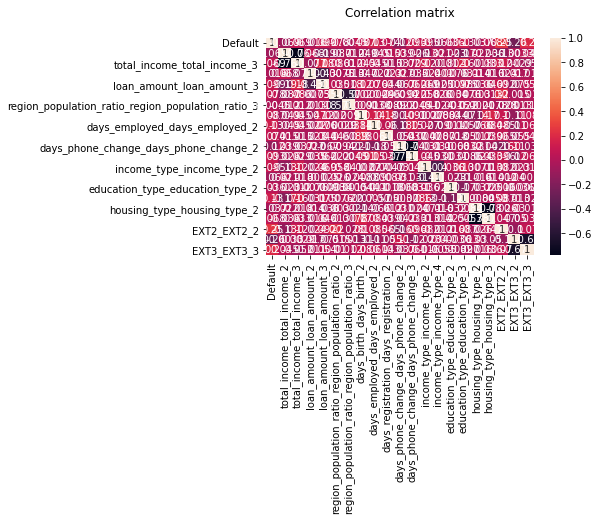

In [58]:
# Feature selection based on correlation
corr = Train_data_2.corr()
hm = sns.heatmap(corr, annot = True)
hm.set(title = "Correlation matrix\n")
plt.show()

In [59]:
# Remove correlated variables
upper_tri = corr.where(np.triu(np.ones(corr.shape),k=1).astype(np.bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.7)]
Train_data_2 = Train_data_2.drop(Train_data_2[to_drop], axis=1)
Valid_data_2 = Valid_data_2.drop(Valid_data_2[to_drop], axis=1)
test_data_2 = test_data_2.drop(test_data_2[to_drop], axis=1)

<ipython-input-59-e49d4cf0c222>:1: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations



## Cost Sensitive 
Since our problem represents class distribution, the **AUC** is a bit misleading if taken just by itself. A good AUC can't tell whether we are correctly predicting the minority class. In this case, I thought about applying missclassification cost through **Cost-sensitive learning**.  
First, I compute the **cost matrix** taking into consideration that the company's Loss given default is defined as 75%, and risk-free interest rate is defined as 1.5%.  

Based on this, I will calculate the total cost for each threshold value going from 0 to 1 by a 0.001 step. After tunning the threshold, I extracted the one with least cost that corresponds to **0.194**. 

I then run *Logistic Regression*, *Random Forest*, *ADA Boost* and *Light Gradient Boosting* models with grid search for hyperparameter tuning and I evaluate their results using the **F1 score** and the **AUC** while using the new threshold.  

According to the benchmarking we did, the most performing model is **logistic regression** with an **AUC of 0.679** and an **F1 of 0.181** on test set. The choice also was made considering the minimum cost as this model generated the least **cost on test set of 51.760.** 

When checking the logistic regression coeffecients of variables, I found that when the borrower has a **lower secondary education**, this increases the probability of his default by 207%, and when he has an **aacademic degree, incomplete higher education or secondary special eduction** his probability of default will be increased by 95% when all the other variables are constant.   

In addition to that, a rise in the *1st* till the *10th* quantile of the variable **EXT2** increases the probability to default by 139%, while keeping all the other variables unchanged.   

The **type of housing** has a considerable impact on defaulting too, since when they live in a *rented appartement or with their parents*, the probability of them defaulting will be rised by 60% with the other variables being constant. 

In [60]:
X_train_re = Train_data_2[Train_data_2.columns[~Train_data_2.columns.isin(['Default'])]]
y_train_re = Train_data_2[target]
X_valid_re = Valid_data_2[Valid_data_2.columns[~Valid_data_2.columns.isin(['Default'])]]
y_valid_re = Valid_data_2[target]
X_test_re = test_data_2[test_data_2.columns[~test_data_2.columns.isin(['Default'])]]
y_test_re = test_data_2[target]

In [61]:
# Annuity
def A(am, ir_c, n):
    return am * (ir_c*(1+ir_c)**n) / ((1+ir_c)**n - 1)

# Present Value
def PV(A, ir_rf, n):
    return A * (1-1/((1+ir_rf)**n)) / ir_rf

In [62]:
def cost_FP(am, n, ir_c, ir_rf=0.015):
    return PV(A(am,ir_c,n),ir_rf,n) - am

def cost_FN(am, lgd=0.75):
    return am*lgd

In [63]:
# compute cost matrix
# transform months -> years

cm_train = pd.DataFrame()
cm_train["cFP"] = cost_FP(Train_re[c]["loan_amount"], Train_re[c]["term"]/12, Train_re[c]["interest_rate"]/100)
cm_train["cFN"] = cost_FN(Train_re[c]["loan_amount"])
cm_train["cTP"] = 0.0
cm_train["cTN"] = 0.0

cm_valid = pd.DataFrame()
cm_valid["cFP"] = cost_FP(X_valid["loan_amount"], X_valid["term"]/12, X_valid["interest_rate"]/100)
cm_valid["cFN"] = cost_FN(X_valid["loan_amount"])
cm_valid["cTP"] = 0.0
cm_valid["cTN"] = 0.0

cm_test = pd.DataFrame()
cm_test["cFP"] = cost_FP(X_test["loan_amount"], X_test["term"]/12, X_test["interest_rate"]/100)
cm_test["cFN"] = cost_FN(X_test["loan_amount"])
cm_test["cTP"] = 0.0
cm_test["cTN"] = 0.0

In [64]:
cm_train

,cFP,cFN,cTP,cTN
0,31066.551158,509625.000,0.0,0.0
1,35654.536799,970126.875,0.0,0.0
2,45431.044617,1028403.000,0.0,0.0
3,24446.179935,517934.250,0.0,0.0
4,6537.607942,199125.000,0.0,0.0
...,...,...,...,...
15570,1625.812282,404325.000,0.0,0.0
15571,7256.448901,155547.000,0.0,0.0
15572,27871.745139,481146.750,0.0,0.0
15573,48835.869385,553864.500,0.0,0.0


In [65]:
def total_cost(true, pred, cTP, cFN, cFP, cTN):
    tc= true*(pred*cTP+(1-pred)*cFN)+(1-true)*(pred*cFP+(1-pred)*cTN)
    return tc

In [66]:
def tune_threshold(true, proba, cm):
    thresholds = np.arange(0, 1, 0.001)
    costs = [np.sum(total_cost(true, np.array(proba > t, dtype=int), **cm)) for t in thresholds]
    return thresholds, costs

## Modeling

In [67]:
#Setup Grid search for logistic regression model
logistic = LogisticRegression()
ada = AdaBoostClassifier()
rf = RandomForestClassifier()
lgb = LGBMClassifier()
models = {"logistic":logistic, "ada":ada, "rf":rf, "lgbm":lgb}

# grid search values 
grid_values = {
                "logistic":{
                    "solver":["liblinear"],
                    'penalty': ['l1', 'l2'],
                    'C':[0.25, 0.5, 1, 3], 
                    "max_iter":[200,300],
                    "class_weight": ["balanced"]
                },
                "ada":{
                    'n_estimators':[100, 500,700,1000],
                    'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1.0]
                }, 
                "rf":{
                    "max_depth":[3,5,10,15,20,None],
                    "min_samples_split":[2,5,7,10],
                    "min_samples_leaf":[1,2,5]
                }, 
                "lgbm": {
                    'boosting_type':['gbdt','dart','goss','rf'],
                    'num_leaves':[51,61,71],
                    'max_depth':[5,6,7],
                    'n_estimators':[50,100]
                }
            }

In [68]:
# evaluation metrics
def eval_metrics_cs(proba, true, cm, t=0.5):
    proba = np.asarray(proba)
    true = np.asarray(true, dtype=int)
    pred = np.array(proba > t, dtype=int) # probability threshold

    auc = roc_auc_score(true, proba)
    f1 = f1_score(true, pred)
    cost = np.sum(total_cost(true, pred, **cm))

    return {
        'AUC': auc,
        'F1': f1,
        "Cost": cost,
    }

In [69]:
data_temp = {
    "X_train":X_train_re,
    "y_train":y_train_re.values.ravel(),
    "X_valid":X_valid_re,
    "y_valid":y_valid_re.values.ravel(),
    "cm_train":cm_train,
    "cm_valid":cm_valid,
}

model_dict = defaultdict(dict)
metric_dict = defaultdict(dict)

#loop through models in models dictionary
for name, model in models.items():
    model_dict[name], metric_dict = run_GridSearch(name=name, data=data_temp, model=model, param_grid=grid_values[name], metrics=metric_dict)

logistic: {'C': 0.5, 'class_weight': 'balanced', 'max_iter': 200, 'penalty': 'l2', 'solver': 'liblinear'}
train:  AUC: 0.7291	F1: 0.6124
valid:  AUC: 0.7004	F1: 0.2427
          pred:no  pred:yes
true:no      1412      1142
true:yes       69       194
ada: {'learning_rate': 0.1, 'n_estimators': 700}
train:  AUC: 0.7290	F1: 0.5221
valid:  AUC: 0.7001	F1: 0.2481
          pred:no  pred:yes
true:no      1800       754
true:yes      119       144
rf: {'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 7}
train:  AUC: 0.7299	F1: 0.5055
valid:  AUC: 0.7042	F1: 0.2625
          pred:no  pred:yes
true:no      1877       677
true:yes      121       142


C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


54 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
54 fits failed with the following error:
Traceback (most recent call last):
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "C:\tools\Anaconda3\envs\py\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = trai

lgbm: {'boosting_type': 'dart', 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 51}
train:  AUC: 0.7416	F1: 0.5762
valid:  AUC: 0.6953	F1: 0.2437
          pred:no  pred:yes
true:no      1664       890
true:yes      103       160


In [70]:
# fitting models with their best parameters
logistic_cs = LogisticRegression(**model_dict["logistic"].best_params_)
logistic_cs.fit(X_train_re,y_train_re.values.ravel())
rf_cs = RandomForestClassifier(**model_dict["rf"].best_params_)
rf_cs.fit(X_train_re,y_train_re.values.ravel())
ada_cs = AdaBoostClassifier(**model_dict["ada"].best_params_)
ada_cs.fit(X_train_re,y_train_re.values.ravel())
lgbm_cs = LGBMClassifier(**model_dict["ada"].best_params_)
lgbm_cs.fit(X_train_re,y_train_re.values.ravel())
models_cs = {"logistic":logistic_cs, "ada":ada_cs, "rf":rf_cs, "lgbm":lgbm_cs}

In [71]:

costs_dict = defaultdict(dict)
thresholds_dict = defaultdict(dict)
index = defaultdict(dict)
cmtx= defaultdict(dict)
EVAL = defaultdict(dict)

for name in models_cs.keys():
    thresholds_dict[name], costs_dict[name] = tune_threshold(y_train_re.values.ravel(), models_cs[name].predict_proba(X_train_re)[:,1], cm_train)
    print(name)
    # best threshold
    index[name] = np.argmin(costs_dict[name])
    print(thresholds_dict[name][index[name]],costs_dict[name][index[name]])

 # save performance validation

    # # evaluate cutoff on all data sets
    EVAL[name+"_cutoff"]["train"] = eval_metrics_cs(models_cs[name].predict_proba(X_train_re)[:,1], y_train_re.values.ravel(), cm_train, t=thresholds_dict[name][np.argmin(costs_dict[name])])
    EVAL[name+"_cutoff"]["valid"] = eval_metrics_cs(models_cs[name].predict_proba(X_valid_re)[:,1], y_valid_re.values.ravel(), cm_valid, t=thresholds_dict[name][np.argmin(costs_dict[name])])
    EVAL[name+"_cutoff"]["test"] = eval_metrics_cs(models_cs[name].predict_proba(X_test_re)[:,1], y_test_re.values.ravel(), cm_test, t=thresholds_dict[name][np.argmin(costs_dict[name])])
    print(name+"_cutoff")

    cmtx[name] = pd.DataFrame(
        confusion_matrix(y_valid, np.array(model_dict[name].predict_proba(X_valid_re)[:,1] > thresholds_dict[name][np.argmin(costs_dict[name])], dtype=int)), 
        index=['true:no', 'true:yes'], 
        columns=['pred:no', 'pred:yes'])
    print(cmtx[name])

logistic
0.194 180871178.1824686
logistic_cutoff
          pred:no  pred:yes
true:no       287      2267
true:yes        8       255
ada
0.493 182344757.00804082
ada_cutoff
          pred:no  pred:yes
true:no       271      2283
true:yes        7       256
rf
0.17 183287630.49128243
rf_cutoff
          pred:no  pred:yes
true:no       277      2277
true:yes        8       255
lgbm
0.131 136534623.84625122
lgbm_cutoff
          pred:no  pred:yes
true:no       352      2202
true:yes        9       254


In [153]:
# Display full overview
overview = pd.DataFrame(pd.concat({k: pd.DataFrame(v) for k,v in EVAL.items()}, axis=1)).T

# convert cost to million
overview["Cost"] /= 1_000_000
overview["AUC"] = round(overview["AUC"],3)
overview["F1"] = round(overview["F1"],3)

overview

AUC     F1        Cost
logistic_cutoff train  0.729  0.603  180.871178
                valid  0.700  0.183   49.204611
                test   0.679  0.181   51.760943
ada_cutoff      train  0.729  0.601  182.344757
                valid  0.700  0.183   49.314945
                test   0.679  0.180   52.193167
rf_cutoff       train  0.729  0.603  183.287630
                valid  0.703  0.183   48.820047
                test   0.683  0.181   51.940363
lgbm_cutoff     train  0.858  0.660  136.534624
                valid  0.648  0.195   50.198882
                test   0.649  0.190   52.741873

In [170]:
coef_imp = pd.concat([pd.DataFrame(logistic_cs.feature_names_in_, columns=['Variables']),pd.DataFrame(logistic_cs.coef_.reshape(20,1), columns=['Coef'])], axis=1)

In [194]:
coef_imp["odds"]= np.exp(coef_imp["Coef"])

In [210]:
Top_5 = coef_imp.sort_values(by="odds", ascending=False)[:5]

In [214]:
Top_5.Variables

13    education_type_education_type_2
17                        EXT2_EXT2_2
14    education_type_education_type_3
16        housing_type_housing_type_3
7       days_employed_days_employed_2
Name: Variables, dtype: object

In [215]:
for i,j in zip(range(0,5),Top_5.Variables):
    print('\n An additional',j,  'increases the probability to default by {:.3f}%'.format( abs(Top_5.iloc[i][2] - 1)*100))


 An additional education_type_education_type_2 increases the probability to default by 207.509%

 An additional EXT2_EXT2_2 increases the probability to default by 138.921%

 An additional education_type_education_type_3 increases the probability to default by 94.806%

 An additional housing_type_housing_type_3 increases the probability to default by 60.122%

 An additional days_employed_days_employed_2 increases the probability to default by 43.301%


In [ ]:
for i in woe_vars:
    print(str(i))
    print(d["woe_" + str(i)].fit_dict)

total_income
{'8': 'total_income_1', '11': 'total_income_2', '13': 'total_income_2', '14': 'total_income_2', '15': 'total_income_2', '12': 'total_income_2', '10': 'total_income_2', '5': 'total_income_3', '3': 'total_income_3', '7': 'total_income_3', '1': 'total_income_3', '9': 'total_income_3', '0': 'total_income_3', '2': 'total_income_3', '6': 'total_income_3', '4': 'total_income_3', 'nan': 'total_income_nan'}
loan_amount
{'17': 'loan_amount_1', '14': 'loan_amount_1', '19': 'loan_amount_1', '0': 'loan_amount_1', '18': 'loan_amount_1', '15': 'loan_amount_1', '13': 'loan_amount_2', '16': 'loan_amount_2', '3': 'loan_amount_3', '10': 'loan_amount_3', '2': 'loan_amount_3', '11': 'loan_amount_3', '5': 'loan_amount_3', '7': 'loan_amount_3', '12': 'loan_amount_3', '8': 'loan_amount_3', '4': 'loan_amount_3', '6': 'loan_amount_3', '9': 'loan_amount_3', '1': 'loan_amount_3', 'nan': 'loan_amount_nan'}
region_population_ratio
{'19': 'region_population_ratio_1', '12': 'region_population_ratio_1', '

## Scorecard  
The final step is creating a simple, credit scorecard that can be used to calculate an individual’s credit score given certain required information about him and his credit history.  

I will then determine the minimum and maximum scores that our scorecard should spit out. As a starting point, we will use the same range of scores used by **FICO**: from 300 to 850.  

The coefficients returned by the logistic regression model for each feature category, are then scaled to the range of credit scores that I set through simple arithmetic. An additional step here is to update the model intercept’s credit score through further scaling that will then be used as the starting point of each scoring calculation.

After ploting the cumulative score curve and divide the plot into bins according to the socre range, we can say that tha majority of clients on the test set have **fair** to **good** scores varying between **630** and **719**. 

In [73]:
def score_func(logit, params, intercept, target=850, target_odds=60, pdo=30):
    
    factor = pdo / np.log(2)
    offset = target - factor * np.log(target_odds)

    # regression model predicts default, therefore: factor*logit is deducted from offset
    score  = offset/params - factor * (logit + intercept/params)
    
    return score

In [218]:
# get model intercept
ic = logistic_cs.intercept_.item()

# compute log odds (coef * value)
df_logit = X_test_re * logistic_cs.coef_


# compute score for all applicants
df_score = score_func(df_logit, df_logit.shape[1], ic)

# compute row sums (total score per applicant) and sort values
sum_sort = np.sort(np.sum(df_score, axis=1))

In [252]:
np.sum(df_score, axis=1)

0       663.323082
1       725.763992
2       673.846006
3       733.198161
4       741.068529
           ...    
2809    713.054752
2810    663.181524
2811    655.075596
2812    640.477500
2813    678.275648
Length: 2814, dtype: float64

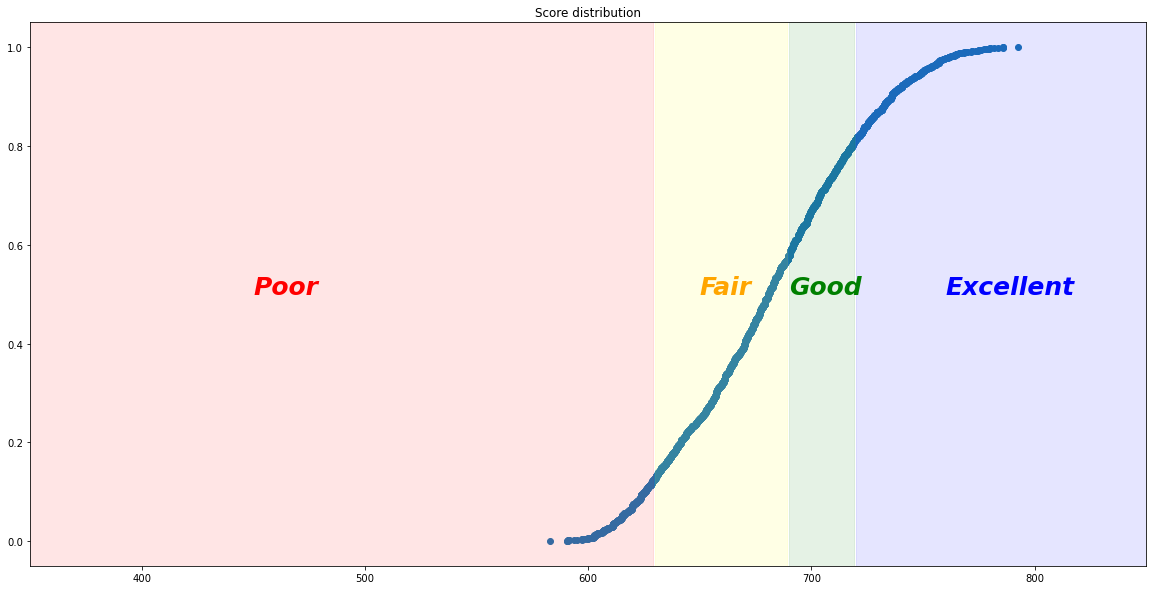

In [219]:
f, axes = plt.subplots(figsize=(20, 10))
plt.xlim(350,850)
plt.scatter(sum_sort, np.cumsum(sum_sort)/sum(sum_sort))
plt.axvspan(300,629, alpha=0.1, color='red')
plt.axvspan(630, 689, alpha=0.1, color='yellow')
plt.axvspan(690, 719, alpha=0.1, color='green')
plt.axvspan(720, 850, alpha=0.1, color='blue')
plt.text(450, 0.5, 'Poor', color='red', fontweight='bold', style='italic', fontsize=25)
plt.text(650, 0.5, 'Fair', color='orange', fontweight='bold', style='italic', fontsize=25)
plt.text(690, 0.5, 'Good', color='green', fontweight='bold', style='italic', fontsize=25)
plt.text(760, 0.5, 'Excellent', color='blue', fontweight='bold', style='italic', fontsize=25)
plt.title('Score distribution')
plt.show()

In [216]:
df_score.mean()

total_income_total_income_2                          37.444507
total_income_total_income_3                          36.112870
loan_amount_loan_amount_2                            36.525297
loan_amount_loan_amount_3                            31.297637
region_population_ratio_region_population_ratio_2    34.136957
region_population_ratio_region_population_ratio_3    35.966483
days_birth_days_birth_2                              35.563853
days_employed_days_employed_2                        28.838298
days_registration_days_registration_2                32.587753
days_phone_change_days_phone_change_2                41.544167
days_phone_change_days_phone_change_3                37.581275
income_type_income_type_2                            31.644206
income_type_income_type_4                            38.098690
education_type_education_type_2                      36.892596
education_type_education_type_3                      16.011790
housing_type_housing_type_2                          29

## References

- https://medium.com/towards-data-science/how-to-develop-a-credit-risk-model-and-scorecard-91335fc01f03  
- https://ai.plainenglish.io/exploratory-data-analysis-eda-with-python-matplotlib-bb784e1d3dd3  
- https://towardsdatascience.com/8-seaborn-plots-for-univariate-exploratory-data-analysis-eda-in-python-9d280b6fe67f  
- https://www.listendata.com/2015/03/weight-of-evidence-woe-and-information.html  
- https://sundarstyles89.medium.com/weight-of-evidence-and-information-value-using-python-6f05072e83eb  
- https://cemsarier.github.io/algorithm/credit%20scoring/scorecard/woe_binning/  
- https://stats.stackexchange.com/questions/418611/is-iv-really-invariant-to-the-number-of-bins  
- https://github.com/jstephenj14/Monotonic-WOE-Binning-Algorithm  
- https://towardsdatascience.com/attribute-relevance-analysis-in-python-iv-and-woe-b5651443fc04  
- https://github.com/Sundar0989/WOE-and-IV/blob/master/WOE_IV.ipynb  
- https://towardsdatascience.com/how-to-develop-a-credit-risk-model-and-scorecard-91335fc01f03  
- https://blogs.sas.com/content/subconsciousmusings/2019/01/18/building-credit-scorecards-using-statistical-methods-and-business-logic/  
- Credit Scoring course materials 